# TVB-ANNarchy: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

## Izhikevich Spiking network model in ANNarchy

For every neuron $i$ in region node $n$ modelled in ANNarchy as a spiking network:

Membrane potential:

$ \dot{V}_m = n_2V_m^2 + n_1V_m + n_0140 - U_m/C $

$\;\;\;\;\;\;\;- g_{AMPA}(V_m-E_{AMPA}) - g_{GABA}(V_m-E_{GABA}) - g_{BASE}V_m + I_e $

where the conductances follow the equations:

$ \dot{g}_{AMPA} = - g_{AMPA} / \tau_{AMPA} + \left[\sum_k \delta(t-t_k) \right]_{Exc}$

$ \dot{g}_{GABA} = - g_{GABA} / \tau_{GABA} + \left[\sum_k \delta(t-t_k) \right]_{Inh}$

$ \dot{g}_{BASE} = - g_{BASE} / \tau_{BASE} + \left[\sum_k \delta(t-t_k) \right]_{BASE}$

and recovery variable:

$ \dot{U}_m = a(bV_m - U_m)$


When $ V_m > V_{th} $ , $ V_m $ is set to $ c $, and $ U_m $ is incremented by $ d $.

# WORKFLOW:

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_annarchy.config import *

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_annarchy")[0], "data")
fit_data_path = os.path.join(data_path, "ANNarchyFittedModels/dataFits_2020_02_05/databestfits", )
data_mode = "patient" # "control", "patient"
control_data = os.path.join(fit_data_path, "controlleft/OutputSim_Patient08.mat")
patient_data = os.path.join(fit_data_path, "patientleft/OutputSim_Patient09.mat")
if data_mode == "patient":
    subject_data = patient_data
    global_coupling_scaling = 0.3
    dSN_factor = 0.6 # p5: 0.7, p10: 0.65, p9: 0.6
    iSN_factor = 0.6 # p5: 0.5,  p10: 0.55, p9: 0.6
else:
    subject_data = control_data
    global_coupling_scaling = 0.3
    dSN_factor = 0.55
    iSN_factor = 0.55
    
simulation_length = 1500.0
transient = 500.0
start_stimulus = 400.0
init_cond_jitter = 0.0

simulation_mode = "rs" # "stim" # "rs"
stim_target = "STN"    #    "STN",         "GPi"
stim_mode = "mono"       # "bi"  | "mono" | "simple"
                       # -------------------------
stim_freq = 120.0      # 130.0 |  120.0 |    0.0 
stim_ampl = -35.0      #  20.0 |  -35.0 |  -10.0 
stim_duration = 0.3    #   0.3 |    0.3 |    0.0
if simulation_mode == "stim":
    simulation_mode = simulation_mode + "_%s_%s" % (stim_target, stim_mode)

outputs_path = os.path.join(work_path, "outputs/outputs_Izhikevich_annarchy_updated")
sim_mode_path = os.path.join(outputs_path, "TVBcortex", data_mode, simulation_mode)
config = Config(output_base=sim_mode_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'eps'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 


## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

In [2]:
from tvb_multiscale.core.tvb.cosimulator.models.reduced_wong_wang_exc_io import ReducedWongWangExcIO

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb.datatypes.connectivity import Connectivity
from tvb_multiscale.core.tvb.cosimulator.cosimulator import CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG
    

# 0. GPe_Left, 1. GPi_Left, 2. STN_Left, 3. Striatum_Left, 4. Thal_Left
BG_opt_matrix_weights = np.zeros((5, 5))
conn_mode = "subject" # "average"
if conn_mode == "average":
    weights_maith = np.array([1.93, 3.56, 1.46, 4.51, 3.52, 2.30, 2.34, 3.78, 1.98, 
                             1.30, 1.82, 3.56, 3.02, 1.78, 1.36, 2.27, 4.13, 2.74, 3.27])*1e-3  # controls
#     weights_maith = np.array([3.27, 3.80, 2.65, 3.66, 3.06, 3.06, 3.25, 4.02, 3.32, 
#                             2.98, 3.45, 3.64, 2.50, 2.12, 2.86, 2.79, 3.96, 3.69, 3.87])*1e-3   # patients
    # probs_maith = ????
else:
    import scipy.io as sio
    conn_path = os.path.join(data_path, "basal_ganglia_conn_incl_cortex")
    weights=sio.loadmat(subject_data)    # weights start from index 19
    weights_maith = weights["X"][0, 19:] # these are indices 19 till 37
    probs_maith = weights["X"][0, :19]   # these are indices 0 till 18

wdSNGPi = BG_opt_matrix_weights[3, 1] = weights_maith[0]
wiSNGPe = BG_opt_matrix_weights[3, 0] = weights_maith[1]
wGPeSTN = BG_opt_matrix_weights[0, 2] = weights_maith[2]
wSTNGPe = BG_opt_matrix_weights[2, 0] = weights_maith[3]
wSTNGPi = BG_opt_matrix_weights[2, 1] = weights_maith[4]
wGPeGPi = BG_opt_matrix_weights[0, 1] = weights_maith[5]  
wGPiTh = BG_opt_matrix_weights[1, 4] = weights_maith[8]
wThdSN = BG_opt_matrix_weights[4, 3] = weights_maith[10] # Th -> dSN
    
sliceBGnet = slice(0,5)

wGPeGPe = weights_maith[6]   # "GPe" -> "GPe" 
wGPiGPi = weights_maith[7]   # "GPi" -> "GPi" 
wThiSN = weights_maith[9]    # "Eth" -> "IiSN" 

wdSNdSN = weights_maith[11]  # "IdSN" -> "IdSN" 
wiSNiSN = weights_maith[12]  # "IiSN" -> "IiSN" 
wCtxdSN = weights_maith[13]  # "CxE" -> "IdSN" 
wCtxiSN = weights_maith[14] # "CxE" -> "IiSN" 
wCtxSTN = weights_maith[15]  # "CxE" -> "Estn"
wCtxEtoI = weights_maith[16] # "CxE" -> "CxI"
wCtxItoE = weights_maith[17] # "CxI" -> "CxE"
wCtxItoI = weights_maith[18] # "CxI" -> "CxI"

pdSNGPi = probs_maith[0]
piSNGPe = probs_maith[1]
pGPeSTN = probs_maith[2]
pSTNGPe = probs_maith[3]
pSTNGPi = probs_maith[4]
pGPeGPi = probs_maith[5]  
pGPeGPe = probs_maith[6]  # "GPe" -> "GPe" 
pGPiGPi = probs_maith[7]  # "GPi" -> "GPi" 
pGPiTh = probs_maith[8]
pThiSN =  probs_maith[9]  # "Eth" -> "IiSN
pThdSN = probs_maith[10] # Th --> dSN
pdSNdSN = probs_maith[11] # "IdSN" -> "IdSN" 
piSNiSN = probs_maith[12] # "IiSN" -> "IiSN" 
pCtxdSN = probs_maith[13]  # "CxE" -> "IdSN" 
pCtxiSN = probs_maith[14] # "CxE" -> "IiSN" 
pCtxSTN = probs_maith[15]  # "CxE" -> "Estn"
pCtxEtoI = probs_maith[16] # "CxE" -> "CxI"
pCtxItoE = probs_maith[17] # "CxI" -> "CxE"
pCtxItoI = probs_maith[18] # "CxI" -> "CxI"
pCtxCtx = probs_maith[16:19].mean() # "Ctx" -> "Ctx"

loadedParams ={'dSNGPi_probs': probs_maith[0],
    	'dSNGPi_weights'  : weights_maith[0],
    	'iSNGPe_probs'   : probs_maith[1],
    	'iSNGPe_weights'  : weights_maith[1],
    	'GPeSTN_probs'   : probs_maith[2],
    	'GPeSTN_weights'  : weights_maith[2],
    	'STNGPe_probs'   : probs_maith[3],
    	'STNGPe_weights'  : weights_maith[3],
    	'STNGPi_probs'   : probs_maith[4],
    	'STNGPi_weights' : weights_maith[4],
    	'GPeGPi_probs'   : probs_maith[5],
    	'GPeGPi_weights'  : weights_maith[5],
    	'GPeGPe_probs'   : probs_maith[6],
    	'GPeGPe_weights'  : weights_maith[6],
    	'GPiGPi_probs'   : probs_maith[7],
    	'GPiGPi_weights'  : weights_maith[7],
    	'GPiThal_probs'   : probs_maith[8],
    	'GPiThal_weights'  : weights_maith[8],
    	'ThaliSN_probs'   : probs_maith[9],
    	'ThaliSN_weights'  : weights_maith[9],
    	'ThaldSN_probs'   : probs_maith[10],
    	'ThaldSN_weights'  : weights_maith[10],
    	'dSNdSN_probs'   : probs_maith[11],
    	'dSNdSN_weights'  : weights_maith[11],
    	'iSNiSN_probs'   : probs_maith[12],
    	'iSNiSN_weights'  : weights_maith[12],
    	'CtxdSN_probs'   : probs_maith[13],
    	'CtxdSN_weights'  : weights_maith[13],
    	'CtxiSN_probs'   : probs_maith[14],
    	'CtxiSN_weights'  : weights_maith[14],
    	'CtxSTN_probs'   : probs_maith[15],
    	'CtxSTN_weights'  : weights_maith[15],
    	'CtxECtxI_probs'    : probs_maith[16],
    	'CtxECtxI_weights'  : weights_maith[16],
    	'CtxICtxE_probs'    : probs_maith[17],
    	'CtxICtxE_weights'  : weights_maith[17],
    	'CtxICtxI_probs'   : probs_maith[18],
    	'CtxICtxI_weights'  : weights_maith[18],
        'CtxThal_weights': 0.0,
        'CtxThal_probs': 1.0}
print(loadedParams)

assert_loadedParams = dict(zip(loadedParams.values(), loadedParams.keys()))


{'dSNGPi_probs': 0.17859516634489409, 'dSNGPi_weights': 0.008694033162319101, 'iSNGPe_probs': 0.33518908071564507, 'iSNGPe_weights': 0.008090356577449711, 'GPeSTN_probs': 0.16505628454033283, 'GPeSTN_weights': 0.005997084264236037, 'STNGPe_probs': 0.3962228806747589, 'STNGPe_weights': 0.011259651579748606, 'STNGPi_probs': 0.24895916907698845, 'STNGPi_weights': 0.012728955057755228, 'GPeGPi_probs': 0.3252567500370787, 'GPeGPi_weights': 0.006170218545084936, 'GPeGPe_probs': 0.32325378120003734, 'GPeGPe_weights': 0.006765628813882359, 'GPiGPi_probs': 0.3371743973897537, 'GPiGPi_weights': 0.01216071144597663, 'GPiThal_probs': 0.24578932343574705, 'GPiThal_weights': 0.007014219544362278, 'ThaliSN_probs': 0.13343960522906853, 'ThaliSN_weights': 0.005992356203860255, 'ThaldSN_probs': 0.12055055752571203, 'ThaldSN_weights': 0.012069912539882353, 'dSNdSN_probs': 0.43455099617713133, 'dSNdSN_weights': 0.007630499957085704, 'iSNiSN_probs': 0.22354489027929958, 'iSNiSN_weights': 0.0141184567240998

Connections of Thalami, Pallidum (GPe/i), Putamen and Caudate (Striatum) removed!:
 [[   0.    0. 2642.    0.  781.    0.  200.    0.]
 [   0.    0.    0. 1034.    0.   45.    0. 1025.]
 [2642.    0.    0.    0. 6058.    0. 1337.    0.]
 [   0. 1034.    0.    0.    0.  162.    0.  381.]
 [ 781.    0. 6058.    0.    0.    0. 1026.    0.]
 [   0.   45.    0.  162.    0.    0.    0.  989.]
 [ 200.    0. 1337.    0. 1026.    0.    0.    0.]
 [   0. 1025.    0.  381.    0.  989.    0.    0.]]
Removing BG -> Cortex connections with max:
1931.34115274226
Removing Cortex -> Thalamus connections with summed weight:
7385.840310132234
Removing BG <- Cortex connections with max:
1682.84151027352

Left cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections:


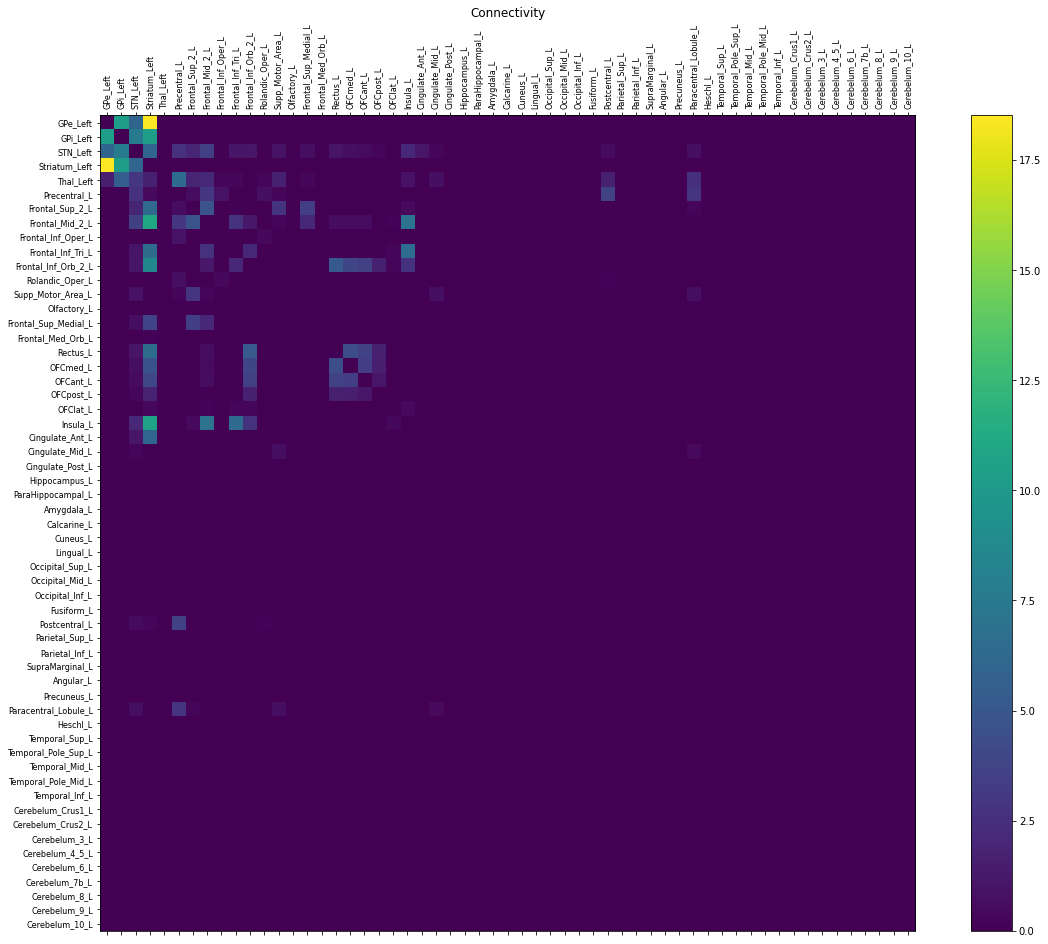

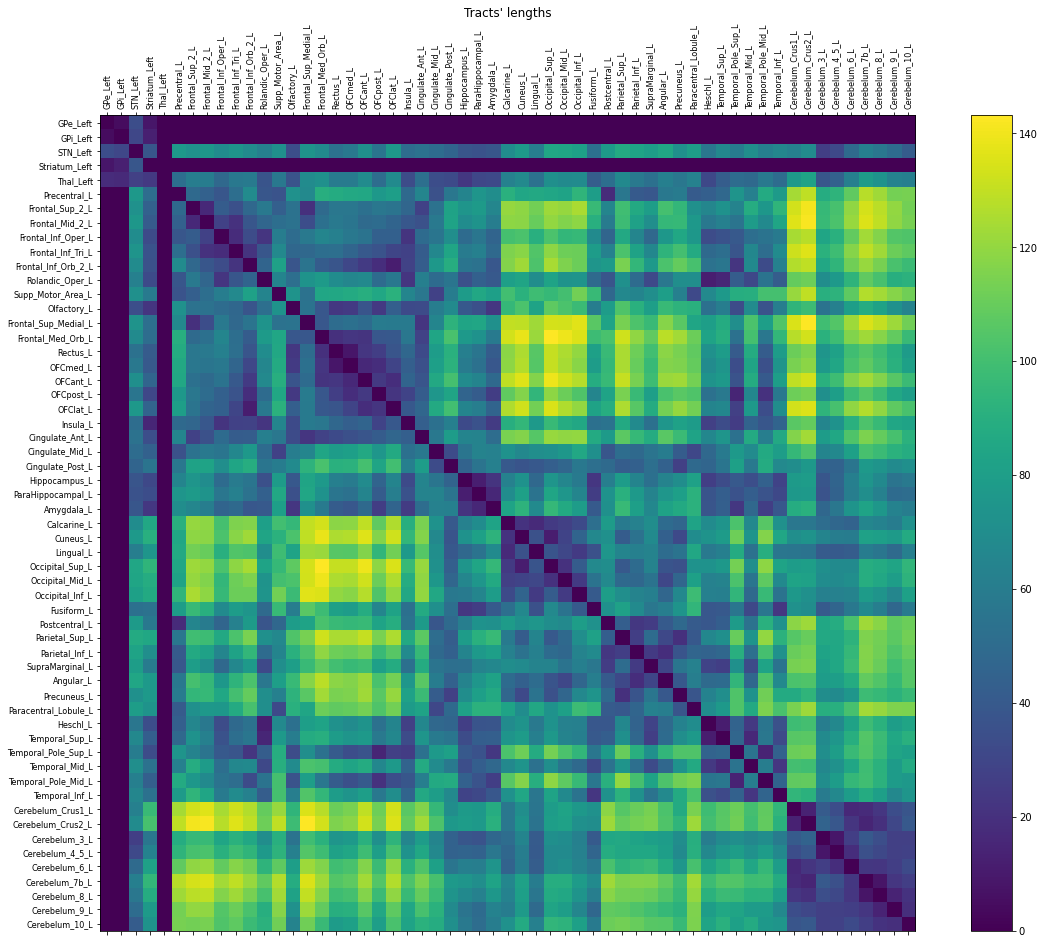

In [3]:
# Load full TVB connectome connectivity

conn_path = os.path.join(data_path, "basal_ganglia_conn")

#Load AAL atlas normative connectome including the Basal Ganglia regions from Petersen et al. atlas
wTVB = np.loadtxt(os.path.join(conn_path, "conn_denis_weights.txt"))
cTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),usecols=range(1,4))
rlTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),dtype="str", usecols=(0,))
tlTVB = np.loadtxt(os.path.join(conn_path, "BGplusAAL_tract_lengths.txt"))

# Remove the second Thalamus, Pallidum (GPe/i), Putamen and Caudate (Striatum):
inds_Th = (rlTVB.tolist().index("Thalamus_L"), rlTVB.tolist().index("Thalamus_R"))
inds_Pall = (rlTVB.tolist().index("Pallidum_L"), rlTVB.tolist().index("Pallidum_R"))
inds_Put = (rlTVB.tolist().index("Putamen_L"), rlTVB.tolist().index("Putamen_R"))
inds_Caud = (rlTVB.tolist().index("Caudate_L"), rlTVB.tolist().index("Caudate_R"))
inds_rm = inds_Th + inds_Pall + inds_Put + inds_Caud
print("Connections of Thalami, Pallidum (GPe/i), Putamen and Caudate (Striatum) removed!:\n", 
      wTVB[inds_rm, :][:, inds_rm])
wTVB = np.delete(wTVB, inds_rm, axis=0)
wTVB = np.delete(wTVB, inds_rm, axis=1)
tlTVB = np.delete(tlTVB, inds_rm, axis=0)
tlTVB = np.delete(tlTVB, inds_rm, axis=1)
rlTVB = np.delete(rlTVB, inds_rm, axis=0)
cTVB = np.delete(cTVB, inds_rm, axis=0)

number_of_regions = len(rlTVB)
speed = np.array([4.0])
min_tt = speed.item() * 0.1
sliceBG = [0, 1, 2, 3, 6, 7]
sliceCortex = slice(10, number_of_regions)

# Remove BG -> Cortex connections
print("Removing BG -> Cortex connections with max:")
print(wTVB[sliceBG, :][:, sliceCortex].max())
wTVB[sliceBG, sliceCortex] = 0.0
tlTVB[sliceBG, sliceCortex] = min_tt

# Remove Cortex -> Thalamus connections
sliceThal = [8, 9]
print("Removing Cortex -> Thalamus connections with summed weight:")
print(wTVB[:, 4].sum())
wTVB[:, sliceThal] = 0.0
tlTVB[:, sliceThal] = min_tt

# Remove GPe/i <- Cortex connections
sliceBG = [0, 1, 2, 3]
print("Removing BG <- Cortex connections with max:")
print(wTVB[sliceCortex, :][:, sliceBG].max())
wTVB[sliceCortex, sliceBG] = 0.0
tlTVB[sliceCortex, sliceBG] = min_tt

connTVB = Connectivity(region_labels=rlTVB, weights=wTVB, centres=cTVB, tract_lengths=tlTVB, speed=speed)

# Normalize connectivity weights
connTVB.weights = connTVB.scaled_weights(mode="region")
connTVB.weights /= np.percentile(connTVB.weights, 99)

# Keep only left hemisphere and remove Vermis:
sliceLeft = slice(0, connTVB.number_of_regions -8, 2)

connLeft = Connectivity(region_labels=connTVB.region_labels[sliceLeft], 
                        centres=connTVB.centres[sliceLeft],
                        weights=connTVB.weights[sliceLeft][:, sliceLeft],
                        tract_lengths=connTVB.tract_lengths[sliceLeft][:, sliceLeft], 
                       speed=connTVB.speed)
connLeft.configure()

print("\nLeft cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections:")
plotter.plot_tvb_connectivity(connLeft);



Left BG TVB network:


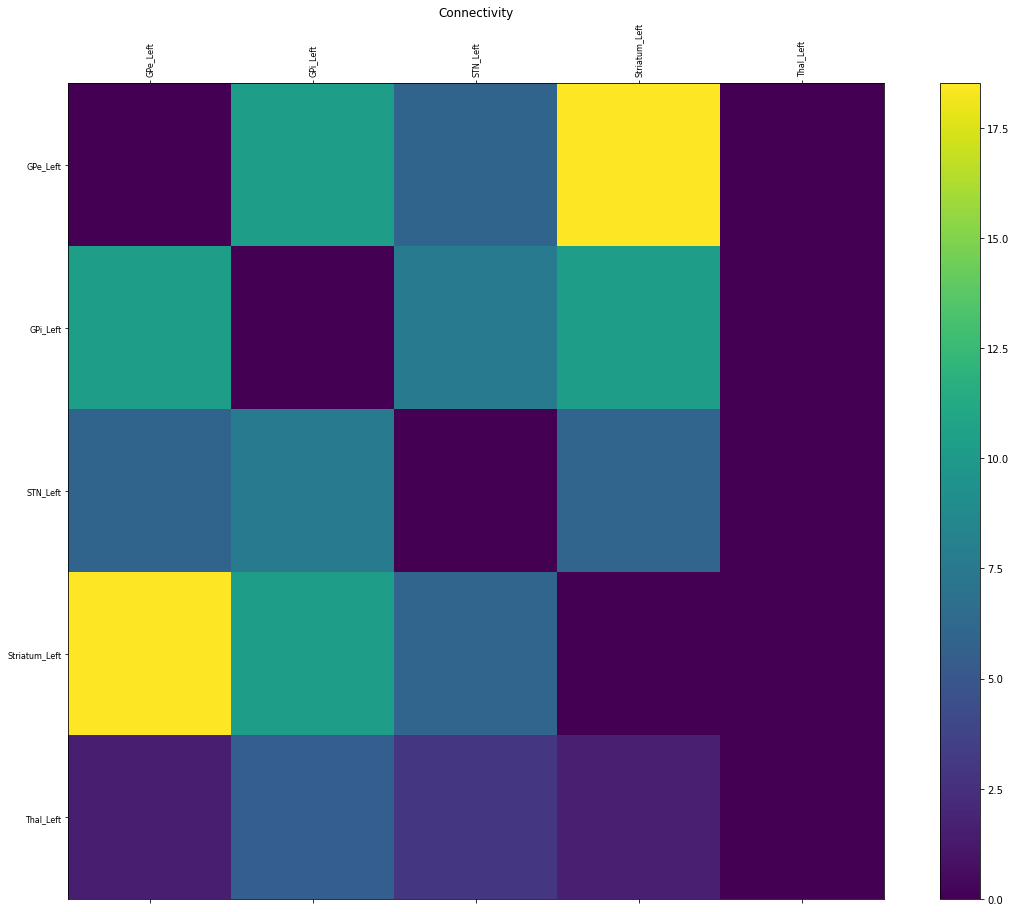

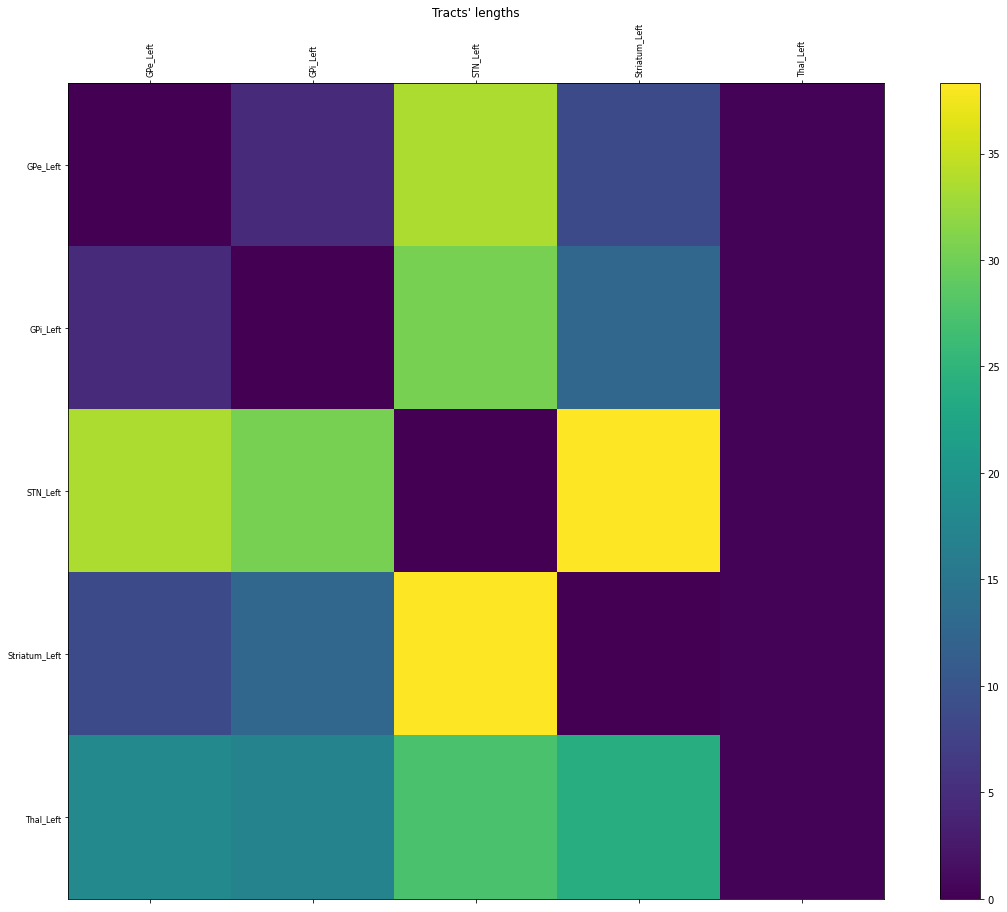

In [4]:
sliceBGnet = slice(0,5)
connTVBleftBG = Connectivity(region_labels=connLeft.region_labels[sliceBGnet], 
                             centres=connLeft.centres[sliceBGnet],
                             weights=connLeft.weights[sliceBGnet][:, sliceBGnet],
                             tract_lengths=connLeft.tract_lengths[sliceBGnet][:, sliceBGnet], 
                            speed=connLeft.speed)
connTVBleftBG.configure()

print("\nLeft BG TVB network:")
plotter.plot_tvb_connectivity(connTVBleftBG);


In [5]:
scaleBGoptTOtvb = np.percentile(BG_opt_matrix_weights, 95) /\
                  np.percentile(connTVBleftBG.weights, 95)
                  
print("Scaling factor of TVB BG network connectome to optimal one = %g" % scaleBGoptTOtvb)


Scaling factor of TVB BG network connectome to optimal one = 0.000705308



Left BG optimized network:


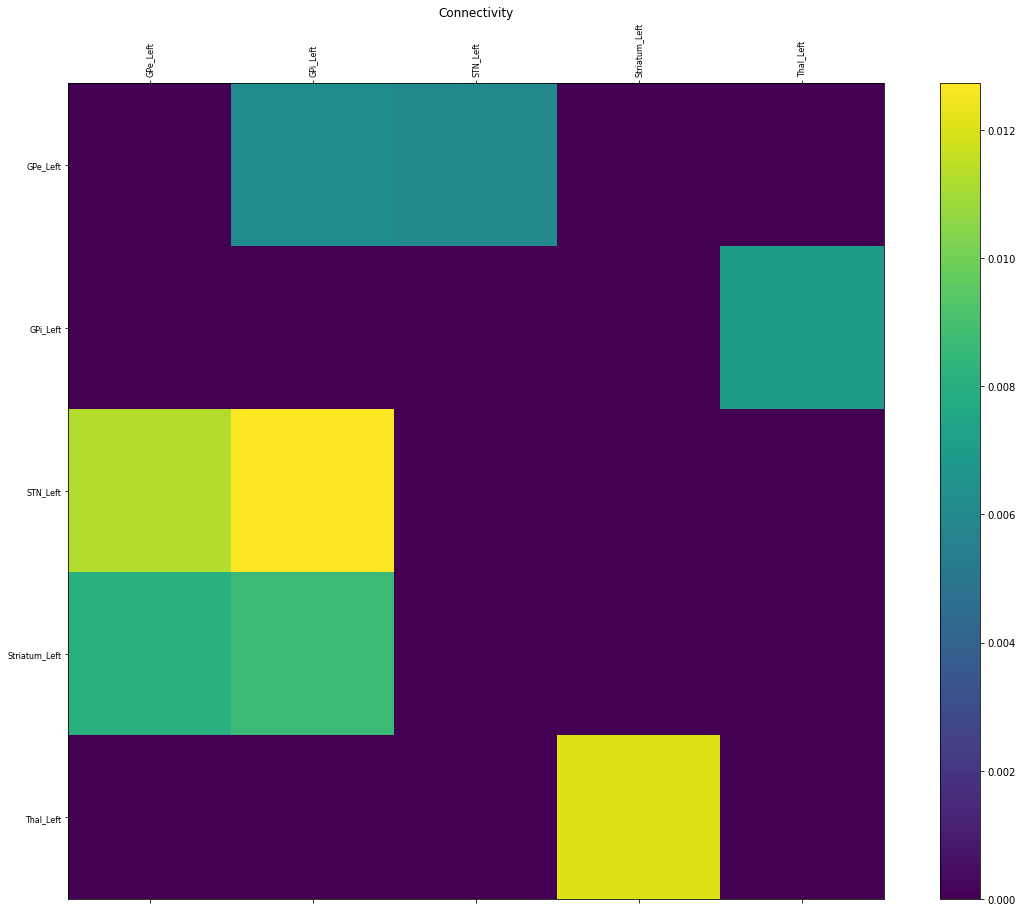

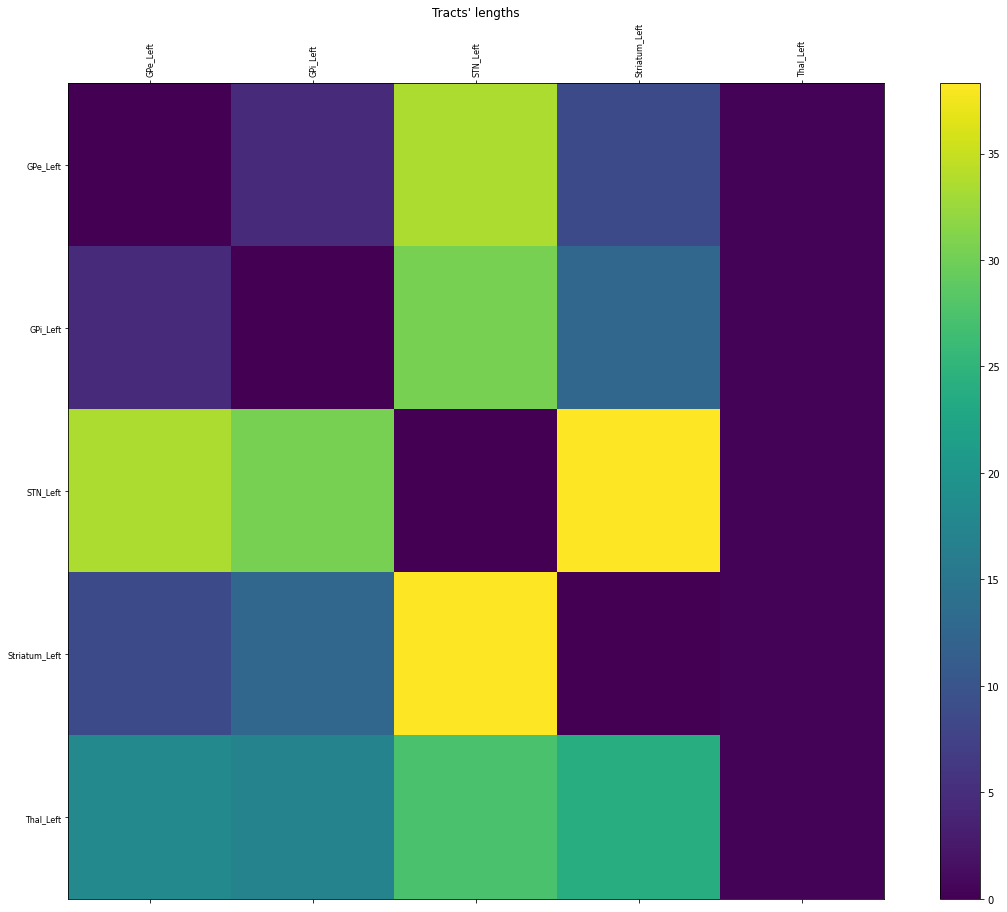

In [6]:
# Construct the final connectivity to use for simulation:
ww = scaleBGoptTOtvb * np.array(connLeft.weights)
ww[sliceBGnet, sliceBGnet] = BG_opt_matrix_weights

connectivity = Connectivity(region_labels=connLeft.region_labels, 
                            centres=connLeft.centres,
                            weights=ww, tract_lengths=connLeft.tract_lengths, 
                            speed=connLeft.speed)
connectivity.configure()

# Construct only the optimized BG connectivity only for plotting:
connBGopt = Connectivity(region_labels=connectivity.region_labels[sliceBGnet], 
                         centres=connectivity.centres[sliceBGnet],
                         weights=connectivity.weights[sliceBGnet][:, sliceBGnet],
                         tract_lengths=connectivity.tract_lengths[sliceBGnet][:, sliceBGnet], 
                         speed=connectivity.speed)
connBGopt.configure()

print("\nLeft BG optimized network:")
plotter.plot_tvb_connectivity(connBGopt);



Connectome used for simulations:


{'integrator.dt': 0.1,
 'connectivity.number_of_regions': 57,
 'connectivity.region_labels': array(['GPe_Left', 'GPi_Left', 'STN_Left', 'Striatum_Left', 'Thal_Left',
        'Precentral_L', 'Frontal_Sup_2_L', 'Frontal_Mid_2_L',
        'Frontal_Inf_Oper_L', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Orb_2_L',
        'Rolandic_Oper_L', 'Supp_Motor_Area_L', 'Olfactory_L',
        'Frontal_Sup_Medial_L', 'Frontal_Med_Orb_L', 'Rectus_L',
        'OFCmed_L', 'OFCant_L', 'OFCpost_L', 'OFClat_L', 'Insula_L',
        'Cingulate_Ant_L', 'Cingulate_Mid_L', 'Cingulate_Post_L',
        'Hippocampus_L', 'ParaHippocampal_L', 'Amygdala_L', 'Calcarine_L',
        'Cuneus_L', 'Lingual_L', 'Occipital_Sup_L', 'Occipital_Mid_L',
        'Occipital_Inf_L', 'Fusiform_L', 'Postcentral_L', 'Parietal_Sup_L',
        'Parietal_Inf_L', 'SupraMarginal_L', 'Angular_L', 'Precuneus_L',
        'Paracentral_Lobule_L', 'Heschl_L', 'Temporal_Sup_L',
        'Temporal_Pole_Sup_L', 'Temporal_Mid_L', 'Temporal_Pole_Mid_L',
      

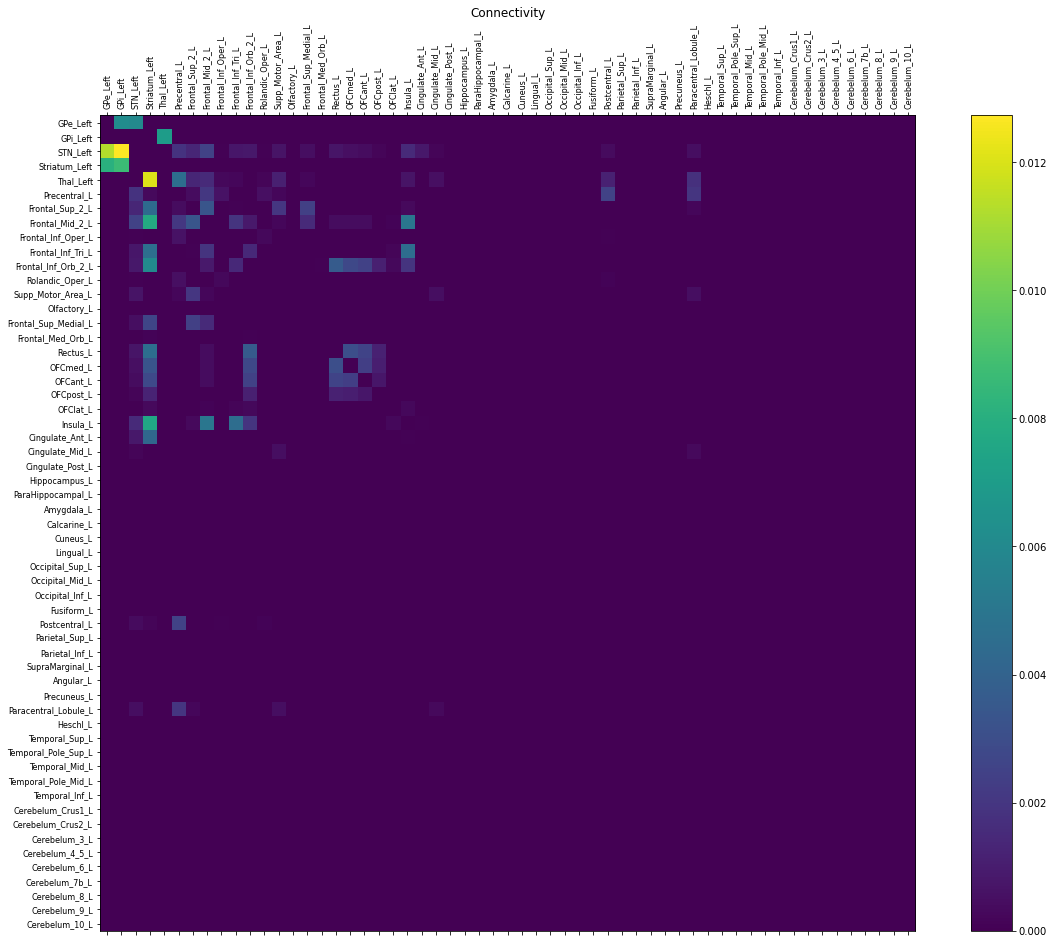

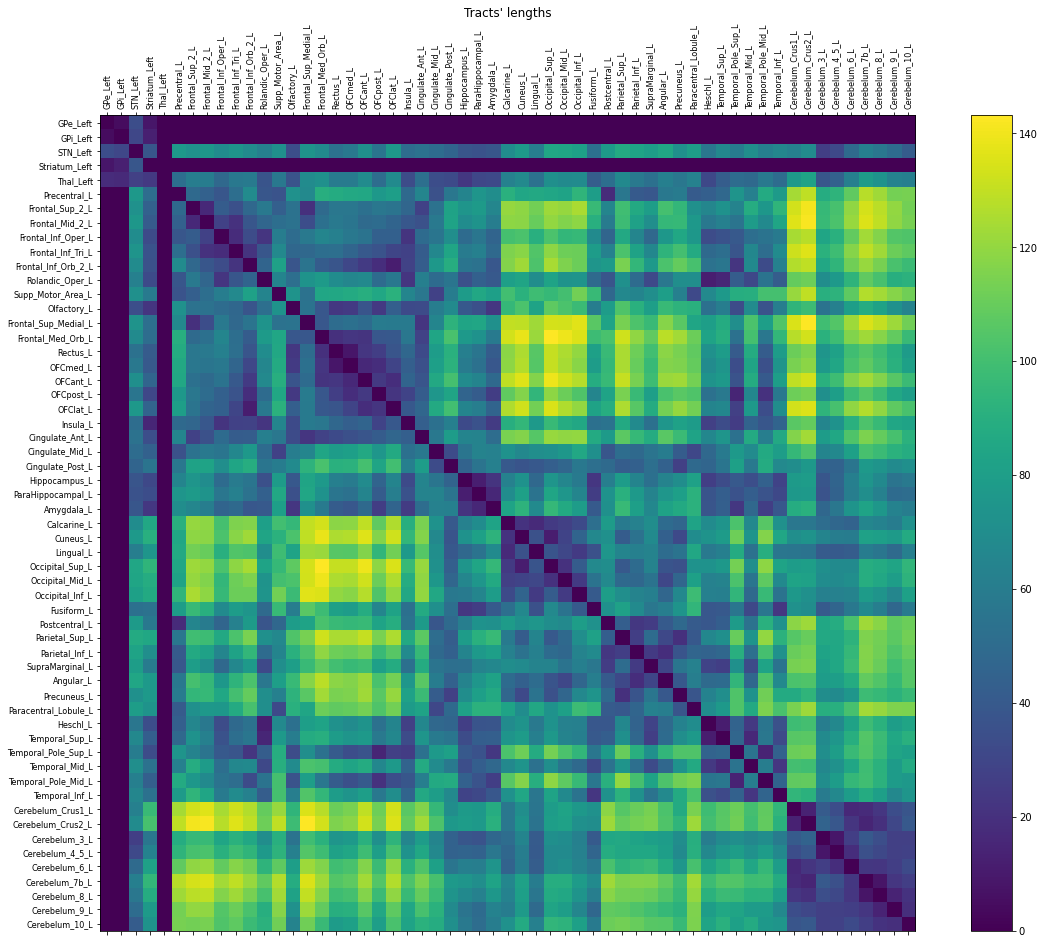

In [7]:
#white_matter_coupling = coupling.Linear(a=0.014)
# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
#simulator.use_numba = False
model_params = {"G": np.array([15.0/scaleBGoptTOtvb])}
simulator.model = ReducedWongWangExcIO(**model_params)

simulator.connectivity = connectivity

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([1e-4])  # 1e-5

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

simulator.connectivity.set_idelays(simulator.integrator.dt)
simulator.horizon = simulator.connectivity.idelays.max() + 1

init_cond_filepath = os.path.join(outputs_path, "tvb_init_cond_left.npy")
init_cond = np.load(init_cond_filepath)   # 
init_cond = np.abs(init_cond *(1 + init_cond_jitter * np.random.normal(size=init_cond.shape)))
simulator.initial_conditions = init_cond * np.ones((simulator.horizon,
                                                    simulator.model.nvar,
                                                    simulator.connectivity.number_of_regions,
                                                    simulator.model.number_of_modes))


print("\nConnectome used for simulations:")
plotter.plot_tvb_connectivity(simulator.connectivity);


# Serializing TVB cosimulator is necessary for parallel cosimulation:
from tvb_multiscale.core.tvb.cosimulator.cosimulator_serialization import serialize_tvb_cosimulator, dump_serial_tvb_cosimulator
sim_serial_filepath = os.path.join(config.out.FOLDER_RES, "tvb_serial_cosimulator.pkl")
sim_serial = serialize_tvb_cosimulator(simulator)
display(sim_serial)

# Dumping the serialized TVB cosimulator to a file will be necessary for parallel cosimulation.
dump_serial_tvb_cosimulator(sim_serial, sim_serial_filepath)



## 2. Build and connect the ANNarchy network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [8]:
from tvb_multiscale.tvb_annarchy.annarchy_models.models.basal_ganglia_izhikevich import BasalGangliaIzhikevichBuilder
from tvb_multiscale.tvb_annarchy.annarchy.models import Izhikevich_Hamker

# Select the regions for the fine scale modeling with ANNarchy spiking networks
#including cortex node:
spiking_nodes_ids = [0, 1, 2, 3, 4]  # the indices of fine scale regions modeled with ANNarchy

# Build a ANNarchy network model with the corresponding builder
ann_model_builder = BasalGangliaIzhikevichBuilder(simulator, spiking_nodes_ids, config=config)
ann_model_builder.configure()


# Using all default parameters for this example
# ann_model_builder.set_defaults()

# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
from copy import deepcopy

population_neuron_model = Izhikevich_Hamker

ann_model_builder.population_order = 200 # reduce for speed

# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

ann_model_builder.params_common = \
    {"E_ampa": 0.0, "E_gaba": -90.0, "v_th": 30.0, "Vr": 0.0, "c": -65.0,
     "C": 1.0, "I": 0.0,
     "tau_syn": 1.0, "tau_ampa": 10.0, "tau_gaba": 10.0,
     "n0": 140.0, "n1": 5.0, "n2": 0.04, 
     "v": -72.0, "u": -14.0, 
     "noise": 0.0}

ann_model_builder._paramsI = deepcopy(ann_model_builder.params_common)
ann_model_builder._paramsI.update({"a": 0.005, "b": 0.585, "d": 4.0, 
                                   "v": -70.0, "u": -18.55})
ann_model_builder._paramsE = deepcopy(ann_model_builder.params_common)
ann_model_builder._paramsE.update({"v": -70.0, "u": -18.55})
ann_model_builder.paramsStr = deepcopy(ann_model_builder.params_common)
ann_model_builder.paramsStr.update({"v_th": 40.0, "C": 50.0, "Vr": -80.0,
                                    "n0": 61.65119, "n1": 2.594639, "n2": 0.022799, 
                                    "a": 0.05, "b": -20.0, "c": -55.0, "d": 377.0, 
                                    "v": -70.0, "u": -18.55})

ann_model_builder.Igpe_nodes_ids = [0]
ann_model_builder.Igpi_nodes_ids = [1]
ann_model_builder.Estn_nodes_ids = [2]
ann_model_builder.Eth_nodes_ids = [4]
ann_model_builder.Istr_nodes_ids = [3]


I_nodes_ids = ann_model_builder.Igpe_nodes_ids + ann_model_builder.Igpi_nodes_ids
E_nodes_ids = ann_model_builder.Estn_nodes_ids + ann_model_builder.Eth_nodes_ids


def paramsE_fun(node_id):
    paramsE = deepcopy(ann_model_builder._paramsE)
    if node_id in ann_model_builder.Estn_nodes_ids:
        paramsE.update({"a": 0.005, "b": 0.265, "d": 2.0, "I": 3.0})  # dictionary of params for Estn
    elif node_id in ann_model_builder.Eth_nodes_ids:
        paramsE.update({"a": 0.02, "b": 0.25, "d": 0.05, "I": 3.5})   # dictionary of params for Eth
    return paramsE
    
def paramsI_fun(node_id):
    # For the moment they are identical, unless you differentiate the noise parameters
    paramsI = deepcopy(ann_model_builder._paramsI)
    if node_id in ann_model_builder.Igpe_nodes_ids:
        paramsI.update({"I": 12.0})
    elif node_id in ann_model_builder.Igpi_nodes_ids:
        paramsI.update({"I": 30.0})
    return paramsI
    
# Populations' configurations
# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property
ann_model_builder.populations = [
    {"label": "E", "model": population_neuron_model,  
     "params":  paramsE_fun, 
     "nodes": E_nodes_ids,  # Estn in [2], Eth in [4]
     "scale": 1.0},
    {"label": "I", "model": population_neuron_model,  
     "params": paramsI_fun, 
     "nodes": I_nodes_ids,  # Igpe in [0], Igpi in [1]
     "scale": 1.0},
    {"label": "IdSN", "model": population_neuron_model,   
     "params": ann_model_builder.paramsStr, 
     "nodes": ann_model_builder.Istr_nodes_ids,  # IdSN in [3]
     "scale": 1.0},
    {"label": "IiSN", "model": population_neuron_model,   # IiSN in [3]
     "params": ann_model_builder.paramsStr, 
     "nodes": ann_model_builder.Istr_nodes_ids,  # None means "all"
     "scale": 1.0}
]

# Within region-node connections
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

# NOTE!!! TAKE CARE OF DEFAULT simulator.coupling.a!
ann_model_builder.global_coupling_scaling = 1.0 # ann_model_builder.coupling_a 
# if we use Reduced Wong Wang model, we also need to multiply with the global coupling constant G:
# ann_model_builder.global_coupling_scaling *= ann_model_builder.G

synapse_model = "DefaultSpikingSynapse"
conn_spec = {'rule': "all_to_all", 
             "allow_self_connections": True, "force_multiple_weights": False}
conn_spec_fixed_probability = conn_spec.copy()
conn_spec_fixed_probability.update({'rule': "fixed_probability", "probability": 0.1})

def conn_spec_fixed_prob(prob=None):
    output = conn_spec_fixed_probability.copy()
    if prob is not None:
        output["probability"] = prob
    return output

within_node_delay = 1.0
        

# for each connection, we have a different probability
ann_model_builder.populations_connections = [
     #        source   ->   target
    {"source": "I", "target": "I",  # I -> I This is a self-connection for population "Igpe"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeGPe),  # conn_spec
     "weight": np.abs(wGPeGPe), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",  # I -> I This is a self-connection for population "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPiGPi),  # conn_spec
     "weight": np.abs(wGPiGPi), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IdSN", "target": "IdSN",  # IdSN -> IdSN This is a self-connection for population "IdSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pdSNdSN),  # conn_spec
     "weight": np.abs(wdSNdSN), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Istr_nodes_ids},
    {"source": "IiSN", "target": "IiSN",  # IiSN -> IiSN This is a self-connection for population "IiSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(piSNiSN),  # conn_spec
     "weight": np.abs(wiSNiSN), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Istr_nodes_ids}
    ]


# Among/Between region-node connections
# Given that only the AMPA population of one region-node couples to
# all populations of another region-node,
# we need only one connection type
        
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# depends on regions, set a handle to a function with
# arguments (source_region_index=None, target_region_index=None)

from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay
        
class TVBWeightFun(object):
    tvb_weights = ann_model_builder.tvb_weights
    global_coupling_scaling = ann_model_builder.global_coupling_scaling
    
    def __init__(self, scale=ann_model_builder.global_coupling_scaling):
        self.tvb_weights = ann_model_builder.tvb_weights
        self.global_coupling_scaling = scale
        
    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(ann_model_builder.tvb_dt, tvb_delay(source_node, target_node, ann_model_builder.tvb_delays))

# Total excitatory spikes of one region node will be distributed to
ann_model_builder.nodes_connections = [
    #        source    ->     target
    {"source": "IdSN", "target": "I",             # "IdSN" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pdSNGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Istr_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IiSN", "target": "I",            # "IiSN" -> "Igpe"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(piSNGPe),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Istr_nodes_ids, 
     "target_nodes": ann_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",             # "Igpe" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpe_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",              # "Igpi" -> "Eth"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPiTh),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpi_nodes_ids, 
     "target_nodes": ann_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",             # "Igpe" -> "Estn"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeSTN),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpe_nodes_ids, 
     "target_nodes": ann_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IdSN",   # "Eth" -> ["IdSN"] 
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pThdSN),  # conn_spec
     "weight": TVBWeightFun(), # wThdSN, # 
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Eth_nodes_ids, 
     "target_nodes": ann_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IiSN",   # "Eth" -> ["IiSN"] 
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pThiSN),  # conn_spec
     "weight": wThiSN,
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Eth_nodes_ids, 
     "target_nodes": ann_model_builder.Istr_nodes_ids},  # No
     {"source": "E", "target": "I",          # "Estn" -> ["Igpe"]
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pSTNGPe),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Estn_nodes_ids, 
     "target_nodes": ann_model_builder.Igpe_nodes_ids},
    {"source": "E", "target": "I",          # "Estn" -> ["Igpi"]
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pSTNGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Estn_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids}
     ]

# Creating  devices to be able to observe ANNarchy activity:

ann_model_builder.output_devices = []

period = 1.0

# Creating  devices to be able to observe ANNarchy activity:
params = deepcopy(ann_model_builder.config.ANNARCHY_OUTPUT_DEVICES_PARAMS_DEF["SpikeMonitor"])
params["period"] = period
for pop in ann_model_builder.populations:
    connections = OrderedDict({})
    #                      label <- target population
    params["label"] = pop["label"]
    connections[params["label"]] = pop["label"]
    ann_model_builder.output_devices.append(
        {"model": "SpikeMonitor", "params": deepcopy(params),
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to "all"

# Labels have to be different for every connection to every distinct population
# params for baladron implementation commented out for the moment
# TODO: use baladron neurons
params = deepcopy(ann_model_builder.config.ANNARCHY_OUTPUT_DEVICES_PARAMS_DEF["Monitor"])
params.update({"period": period,  'record_from': ["v", "u", "I_syn", "I_syn_ex", "I_syn_in", "g_ampa", "g_gaba", "g_base"]})
for pop in ann_model_builder.populations:
    connections = OrderedDict({})
    #               label    <- target population
    connections[pop["label"]] = pop["label"]
    params["label"] = pop["label"] + "_ts"
    ann_model_builder.output_devices.append(
        {"model": "Monitor", "params": deepcopy(params),
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to all
    
    
# # Create a spike stimulus input device
# # including cortex node: we do not need any other external stimulation
# ann_model_builder.Estn_stim = {"rate": 500.0, "weight": 0.009}
# ann_model_builder.Igpe_stim = {"rate": 100.0, "weight": 0.015}
# ann_model_builder.Igpi_stim = {"rate": 700.0, "weight": 0.02}
ann_model_builder.input_devices = [
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Estn_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[0]["scale"](ann_model_builder.Estn_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineEstn"},
#              "connections": {"BaselineEstn": ["E"]},  # "Estn"
#              "nodes": ann_model_builder.Estn_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Estn_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Igpe_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[1]["scale"](ann_model_builder.Igpe_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineIgpe"},
#              "connections": {"BaselineIgpe": ["I"]},  # "Igpe"
#              "nodes": ann_model_builder.Igpe_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Igpe_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Igpi_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[1]["scale"](ann_model_builder.Igpi_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineIgpi"},
#              "connections": {"BaselineIgpi": ["I"]},  # "Igpi"
#              "nodes": ann_model_builder.Igpi_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Igpi_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
       ]  #

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------


annarchy_network = ann_model_builder.build(set_defaults=False)

annarchy_network.print_summary_info_details(recursive=3, connectivity=False)



ANNarchy 4.7 (4.7.0) on linux (posix).
2022-02-18 18:50:16,300 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Loading an ANNarchy instance...
2022-02-18 18:50:16,300 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Loading an ANNarchy instance...
2022-02-18 18:50:16,304 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Cleaning ANNarchy compilation directory, if any...
2022-02-18 18:50:16,304 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Cleaning ANNarchy compilation directory, if any...
2022-02-18 18:50:16,315 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring spiking network builder...
2022-02-18 18:50:16,315 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring spiking network builder...
2022-02-18 18:50:16,320 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations...
2022-02-18 18:50:16,320 - INFO - tvb_multiscale.core.spiking_model

2022-02-18 18:50:17,657 - INFO - tvb_multiscale.core.spiking_models.builders.base - I -> I populations ...
2022-02-18 18:50:17,657 - INFO - tvb_multiscale.core.spiking_models.builders.base - I -> I populations ...
2022-02-18 18:50:17,665 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting for 1 -> 4 spiking region nodes ...
2022-02-18 18:50:17,665 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting for 1 -> 4 spiking region nodes ...
2022-02-18 18:50:17,669 - INFO - tvb_multiscale.core.spiking_models.builders.base - I -> E populations ...
2022-02-18 18:50:17,669 - INFO - tvb_multiscale.core.spiking_models.builders.base - I -> E populations ...
2022-02-18 18:50:17,678 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting for 0 -> 2 spiking region nodes ...
2022-02-18 18:50:17,678 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting for 0 -> 2 spiking region nodes ...
2022-02-18 18:50:17,682 - INFO - tvb_multiscale.

2022-02-18 18:50:17,906 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['IiSN'] -> ['IiSN'] device set of model Monitor
for nodes [3]...
2022-02-18 18:50:17,906 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['IiSN'] -> ['IiSN'] device set of model Monitor
for nodes [3]...
2022-02-18 18:50:17,912 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model Monitor for IiSN created!
2022-02-18 18:50:17,912 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model Monitor for IiSN created!
2022-02-18 18:50:17,920 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting input devices, if any...
2022-02-18 18:50:17,920 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting input devices, if any...
2022-02-18 18:50:17,925 - 

In [9]:
populations_sizes = []
print("Population sizes: ")
for pop in ann_model_builder.populations:
    populations_sizes.append(int(np.round(pop["scale"] * ann_model_builder.population_order)))
    print("%s: %d" % (pop["label"], populations_sizes[-1]))
    

Population sizes: 
E: 200
I: 200
IdSN: 200
IiSN: 200


In [10]:
annarchy_network.print_summary_info_details(recursive=3, connectivity=False)

Failed to serialize: 
brain_regions
ANNarchyBrain
tuple indices must be integers or slices, not tuple
Failed to serialize: 
output_devices
DeviceSets
'Series' object has no attribute 'info_details'
ANNarchyNetwork (
  title ................... 'ANNarchyNetwork gid: 1ffa64bc-4d55-4e48-a122-96fbc96d1ee0'
  Type .................... 'ANNarchyNetwork'
  config .................. '--------------------'
  config.title ............ 'Config gid: 3d1712dd-7399-42ea-8752-522a31cb8781'
  config.Type ............. 'Config'
  config.gid .............. UUID('3d1712dd-7399-42ea-8752-522a31cb8781')
  brain_regions ........... '--------------------'
  output_devices .......... '--------------------'
  input_devices ........... '--------------------'
  input_devices.title ..... 'DeviceSets gid: d2ed667e-158d-4023-8937-3815fc9cc254'
  input_devices.Type ...... 'DeviceSets'
  input_devices.gid ....... UUID('d2ed667e-158d-4023-8937-3815fc9cc254')
  input_devices.label ..... ''
  input_devices.size ...... 0

In [11]:
annarchy_instance = annarchy_network.annarchy_instance

# Izhikevich_Hamker = Neuron(
# parameters="""
#     a = 0.02
#     b = 0.2
#     c = -72.0
#     d = 6.0
#     n0 = 140.
#     n1 = 5.0
#     n2 = 0.04
#     I = 0.0
#     tau_refrac = 10.0
#     tau_ampa = 10.0
#     tau_gaba = 10.0
#     E_ampa = 0.0
#     E_gaba = -90.0
#     tau_syn = 1.0
#     C = 1.0
#     v_th = 30.0
#     Vr = 0.0
#.    noise = 0.0
# """,
# equations="""
#     I_syn_ex = - g_ampa*(v-E_ampa)
#     I_syn_in = - g_gaba*(v-E_gaba)
#     I_syn = I_syn_ex + I_syn_in - g_base*v + g_dbs + noise * Normal(0.0, 1.0)
#     dg_base/dt = -g_base/tau_syn : init = 0
#     dg_ampa/dt = -g_ampa/tau_ampa : init = 0
#     dg_gaba/dt = -g_gaba/tau_gaba : init = 0
#     dv/dt = n2*v*v+n1*v+n0 - u/C  + I + I_syn : init = -72.0
#     du/dt = a*(b*(v-Vr)-u) : init = -14.4
# """,
# spike = """
#     v>=v_th
# """,
# reset = """
#     v = c
#     u = u+d
# """,
# refractory = """tau_refrac"""
# )


# amplitude in mV or V? Was V in Michmizos paper, but had value 5.
# frequency in Hz and later divided by 1000 because time scale is ms
# duration in ms!
#dt inside annarchy needs to be <=0.01 to realize a 60µs pulse width, but setting it to that leads to errors. 
# realistic "duration" parameter for DBSInput would be 0.06

if stim_mode.find("mono") > -1:
    DBSInput = annarchy_instance.Neuron(
        parameters="""
            amplitude = 5.0
            kappa = 8
            frequency = 130
            duration = 0.1
        """,
        equations="""
            h1 = if sin(2*pi*(frequency/1000)*t) > 0 : 1 else : 0
            h2 = if sin(2*pi*(frequency/1000)*(t+duration)) > 0 : 1 else : 0
            r = amplitude*kappa*h1*(1-h2)
        """
    )
elif stim_mode.find("bi") > -1:
    DBSInput = annarchy_instance.Neuron(
        parameters="""
            amplitude = 5.0
            ampfactor = 10
            kappa = 8
            frequency = 130
            duration = 0.3
        """,
        equations="""
            h1 = if sin(2*pi*(frequency/1000)*t) > 0 : 1 else : 0
            h2 = if sin(2*pi*(frequency/1000)*(t-duration)) > 0 : 1 else : 0
            h4 = if sin(2*pi*(frequency/1000)*(t-((ampfactor+1)*duration))) > 0 : 1 else : 0
            i1 = amplitude*(1+ 1/ampfactor)*kappa*h1*(1-h2)
            i2 = (-amplitude/ampfactor) *kappa *h1*(1-h4)
            r = i1 + i2
        """
    )

In [12]:
if simulation_mode != "rs":
    
    if stim_target.find("STN") > -1:
        stim_target = "STN_Left" 
    else:
        stim_target = "GPi_Left" 
        
    if stim_mode != "simple":
        # now add DBS population invisible to TVB for now
        target_pop = annarchy_network.brain_regions[stim_target][0].population
        dbs_pop = annarchy_instance.Population(target_pop.size, DBSInput)
        dbs_proj = annarchy_instance.CurrentInjection(dbs_pop, target_pop, 'dbs')
        dbs_proj.connect_current()
        # switch the stimulation off for the first time segment
        dbs_pop.amplitude = 0
        dbs_pop.frequency = stim_freq
        dbs_pop.duration = stim_duration

        # just to check, add some annarchy monitors -> delete later    
        m1 = annarchy_instance.Monitor(dbs_pop, "r")
        m2 = annarchy_instance.Monitor(target_pop, ["g_dbs", "spike"])


## 3. Build the TVB-ANNarchy interface

In [13]:
from tvb_multiscale.tvb_annarchy.interfaces.models.basal_ganglia_izhikevich import BasalGangliaIzhikevichTVBANNarchyInterfaceBuilder

    
# Build a TVB-ANNarchy interface with all the appropriate connections between the
# TVB and ANNarchy modelled regions
tvb_spikeNet_model_builder = BasalGangliaIzhikevichTVBANNarchyInterfaceBuilder()

tvb_spikeNet_model_builder.config = config
tvb_spikeNet_model_builder.tvb_cosimulator = simulator            
tvb_spikeNet_model_builder.spiking_network = annarchy_network
# This can be used to set default tranformer and proxy models:
tvb_spikeNet_model_builder.model = "RATE"          # "RATE" (or "SPIKES", "CURRENT") TVB->ANNarchy interface
tvb_spikeNet_model_builder.input_flag = True   # If True, ANNarchy->TVB update will be implemented
tvb_spikeNet_model_builder.output_flag = True  # If True, TVB->ANNarchy coupling will be implemented
# If default_coupling_mode = "TVB", large scale coupling towards spiking regions is computed in TVB
# and then applied with no time delay via a single "TVB proxy node" / ANNarchy device for each spiking region,
# "1-to-1" TVB->ANNarchy coupling.
# If any other value, we need 1 "TVB proxy node" / ANNarchy device for each TVB sender region node, and
# large-scale coupling for spiking regions is computed in ANNarchy, 
# taking into consideration the TVB connectome weights and delays, 
# in this "1-to-many" TVB->ANNarchy coupling.
tvb_spikeNet_model_builder.default_coupling_mode = "TVB" 
# Number of neurons per population to be used to compute population mean instantaneous firing rates:
tvb_spikeNet_model_builder.proxy_inds = np.array(spiking_nodes_ids)
tvb_spikeNet_model_builder.N_E = ann_model_builder.population_order
tvb_spikeNet_model_builder.GPe_proxy_inds = np.array(ann_model_builder.Igpe_nodes_ids)
tvb_spikeNet_model_builder.GPi_proxy_inds = np.array(ann_model_builder.Igpi_nodes_ids)
tvb_spikeNet_model_builder.STN_proxy_inds = np.array(ann_model_builder.Estn_nodes_ids)
tvb_spikeNet_model_builder.Striatum_proxy_inds = np.array(ann_model_builder.Istr_nodes_ids)
tvb_spikeNet_model_builder.Thal_proxy_inds = np.array(ann_model_builder.Eth_nodes_ids)

# Set exclusive_nodes = True (Default) if the spiking regions substitute for the TVB ones:
tvb_spikeNet_model_builder.exclusive_nodes = True  

tvb_spikeNet_model_builder.output_interfaces = []
tvb_spikeNet_model_builder.input_interfaces = []
    
   
# options for a nonopinionated builder:
from tvb_multiscale.core.interfaces.base.transformers.models.models import Transformers
from tvb_multiscale.core.interfaces.base.transformers.builders import \
        DefaultTVBtoSpikeNetTransformers, DefaultSpikeNetToTVBTransformers, \
        DefaultTVBtoSpikeNetModels, DefaultSpikeNetToTVBModels
from tvb_multiscale.tvb_annarchy.interfaces.builders import \
        TVBtoANNarchyModels, ANNarchyInputProxyModels, DefaultTVBtoANNarchyModels, \
        ANNarchyToTVBModels, ANNarchyOutputProxyModels, DefaultANNarchytoTVBModels

    
    
def print_enum(enum):
    print("\n", enum)
    for name, member in enum.__members__.items():
        print(name,"= ", member.value)
    
    
print("Available input (NEST->TVB update) / output (TVB->NEST coupling) interface models:")
print_enum(TVBtoANNarchyModels)
print_enum(ANNarchyToTVBModels)
    
    
print("\n\nAvailable input (spikeNet->TVB update) / output (TVB->spikeNet coupling) transformer models:")

print_enum(DefaultTVBtoSpikeNetModels)
print_enum(DefaultTVBtoSpikeNetTransformers)
    
print_enum(DefaultSpikeNetToTVBModels)
print_enum(DefaultSpikeNetToTVBTransformers)    
    
    
print("\n\nAvailable input (NEST->TVB update) / output (TVB->NEST coupling) proxy models:")

print_enum(DefaultTVBtoANNarchyModels)
print_enum(ANNarchyInputProxyModels)
    
print_enum(ANNarchyOutputProxyModels)
print_enum(DefaultANNarchytoTVBModels)
    
print("\n\nAll basic transformer models:")
print_enum(Transformers)


Available input (NEST->TVB update) / output (TVB->NEST coupling) interface models:

 <enum 'TVBtoSpikeNetModels'>
RATE =  0
SPIKES =  1
CURRENT =  2

 <enum 'SpikeNetToTVBModels'>
SPIKES =  0
VOLTAGE =  1


Available input (spikeNet->TVB update) / output (TVB->spikeNet coupling) transformer models:

 <enum 'DefaultTVBtoSpikeNetModels'>
RATE =  RATE
SPIKES =  SPIKES_SINGLE_INTERACTION
CURRENT =  CURRENT

 <enum 'DefaultTVBtoSpikeNetTransformers'>
RATE =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.base.LinearRate'>
SPIKES =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.elephant.RatesToSpikesElephantPoisson'>
SPIKES_SINGLE_INTERACTION =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.elephant.RatesToSpikesElephantPoissonSingleInteraction'>
SPIKES_MULTIPLE_INTERACTION =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.elephant.RatesToSpikesElephantPoissonMultipleInteraction'>
CURRENT =  <class 'tvb_multiscale.core.int

In [14]:

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb_multiscale.core.interfaces.base.transformers.models.red_wong_wang import RedWongWangExc


# TVB -> ANNarchy


# --------For spike transmission from TVB to ANNarchy devices acting as TVB proxy nodes with TVB delays:--------

# tvb_spikeNet_model_builder.G = tvb_spikeNet_model_builder.tvb_simulator.model.G[0].item()
# tvb_spikeNet_model_builder.global_coupling_scaling = tvb_spikeNet_model_builder.tvb_simulator.coupling.a[0].item() * tvb_spikeNet_model_builder.G
tvb_spikeNet_model_builder.global_coupling_scaling = np.array(global_coupling_scaling) # Control: 0.5, Patient: 0.4
print("global_coupling_scaling = %g" % tvb_spikeNet_model_builder.global_coupling_scaling)

# Total TVB weight to STN:
wTVBSTNs = simulator.connectivity.weights[5:, ann_model_builder.Estn_nodes_ids].squeeze()
wTVBSTN = wTVBSTNs.sum()
print("wTVBSTN = %g" % wTVBSTN)
# Total TVB weight to Striatum:
wTVBSNs = simulator.connectivity.weights[5:, ann_model_builder.Istr_nodes_ids].squeeze()
wTVBSN = wTVBSNs.sum()
print("wTVBSN = %g" % wTVBSN)

iwCtxSTN = wCtxSTN / wTVBSTN
print("iwCtxSTN = %g" % iwCtxSTN)
print("wCtxSTN_effective = iwCtxSTN * wTVBSTN = %g = wCtxSTN = %g" % (iwCtxSTN * wTVBSTN, wCtxSTN))
print("w_norm_STN = %g" % (iwCtxSTN * tvb_spikeNet_model_builder.global_coupling_scaling))

# It has to be:
# # wCtxSTN / wCtxdSN = (iwCtxSTN * wTVBSTN) / (iwCtxdSN * wTVBSN) => (solving for iwCtxiSN)
# iwCtxdSN = wCtxdSN * iwCtxSTN * wTVBSTN / (wCtxSTN * wTVBSN) / 100 # interface weight for dSN
iwCtxdSN = dSN_factor*wCtxdSN / wTVBSN  # Control: 0.5, Patient: 0.6  
print("dSN_factor = %g" % dSN_factor)
print("iwCtxdSN = %g" % iwCtxdSN)
print("wCtxdSN_effective = iwCtxdSN * wTVBSN = %g = wCtxdSN = %g" % (iwCtxdSN * wTVBSN, wCtxdSN))
print("w_norm_dSN = %g" % (iwCtxdSN * tvb_spikeNet_model_builder.global_coupling_scaling))

# # wCtxSTN / wCtxiSN = (iwCtxSTN * wTVBSTN) / (iwCtxiSN * wTVBSN) => (solving for iwCtxiSN)
# iwCtxiSN = wCtxiSN * iwCtxSTN * wTVBSTN / (wCtxSTN * wTVBSN) / 100 # interface weight for iSN
iwCtxiSN = iSN_factor*wCtxiSN / wTVBSN  # Control: 0.6, Patient: 0.5
print("iSN_factor = %g" % dSN_factor)
print("iwCtxiSN = %g" % iwCtxiSN)
print("wCtxiSN_effective = iwCtxiSN * wTVBSN = %g = wCtxiSN = %g" % (iwCtxiSN * wTVBSN, wCtxiSN))
print("w_norm_iSN = %g" % (iwCtxiSN * tvb_spikeNet_model_builder.global_coupling_scaling))

tvb_spikeNet_model_builder.output_interfaces = []
# Mean spike rates are applied in parallel to all target neurons
for trg_pop, target_nodes, conn_scaling, this_conn_spec in zip(["E", "IdSN", "IiSN"],
                                                     [tvb_spikeNet_model_builder.STN_proxy_inds, 
                                                      tvb_spikeNet_model_builder.Striatum_proxy_inds, 
                                                      tvb_spikeNet_model_builder.Striatum_proxy_inds], 
                                                     [iwCtxSTN, iwCtxdSN, iwCtxiSN], # [wCtxSTN/52, wCtxdSN/52, wCtxiSN/52],
                                                     [conn_spec_fixed_prob(prob=pCtxSTN), # pCtxSTN  
                                                      conn_spec_fixed_prob(prob=pCtxdSN), # pCtxdSN
                                                      conn_spec_fixed_prob(prob=pCtxiSN)  # pCtxiSN
                                                      ]):          
        tvb_spikeNet_model_builder.output_interfaces.append(
            {"voi": np.array(["R"]),
             "populations": np.array([trg_pop]),
             "model": "RATE", 
             "spiking_proxy_inds": target_nodes,
             "proxy_model": ANNarchyInputProxyModels.RATE_TO_CORRELATED_SPIKES,
             "proxy_params": {"geometry": 600, "corr": 0.3, "tau": 10.0, # pCtxCtx, 1.6*pCtxCtx, # "refractory": 10.0, 
                              "record": ["spike"]}, # TimedArray
             'conn_spec': this_conn_spec,
             'transformer_params': {"scale_factor": np.array(conn_scaling)},
             'coupling_mode': tvb_spikeNet_model_builder.default_coupling_mode
        })  # None means all here

    
from tvb_multiscale.core.interfaces.base.transformers.models.red_wong_wang import ElephantSpikesRateRedWongWangExc

tvb_spikeNet_model_builder.input_interfaces = []
# TVB <-- ANNarchy:
for src_pop, nodes in zip([np.array(["I"]),  np.array(["E"]), np.array(["IdSN", "IiSN"])],
                              [tvb_spikeNet_model_builder.I_proxy_inds, 
                               tvb_spikeNet_model_builder.E_proxy_inds, 
                               tvb_spikeNet_model_builder.Striatum_proxy_inds]):
        #            TVB <- ANNarchy
        tvb_spikeNet_model_builder.input_interfaces.append(
            {"voi": np.array(["S", "R"]), "populations": src_pop,
             "transformer": ElephantSpikesRateRedWongWangExc,
             "transformer_params": {"scale_factor": np.array([1.0]) / tvb_spikeNet_model_builder.N_E,
                                    "integrator":
                                        CONFIGURED.DEFAULT_TRANSFORMER_INTEGRATOR_MODEL(dt=simulator.integrator.dt),
                                    "state": np.zeros((2, len(nodes))),
                                    "tau_s": simulator.model.tau_s,
                                    "tau_r": np.array([10.0]),
                                    "gamma": simulator.model.gamma},
             "proxy_inds": np.array(nodes)})  # None means all here
    

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------

# Configure and build:
tvb_spikeNet_model_builder.configure()
# tvb_spikeNet_model_builder.print_summary_info_details(recursive=1)
    
print("\noutput (TVB->NEST coupling) interfaces' configurations:\n")
display(tvb_spikeNet_model_builder.output_interfaces)
    
print("\ninput (NEST->TVB update) interfaces' configurations:\n")
display(tvb_spikeNet_model_builder.input_interfaces)
    
    


global_coupling_scaling = 0.3
wTVBSTN = 0.013739
wTVBSN = 0.0503774
iwCtxSTN = 0.964986
wCtxSTN_effective = iwCtxSTN * wTVBSTN = 0.0132579 = wCtxSTN = 0.0132579
w_norm_STN = 0.289496
dSN_factor = 0.6
iwCtxdSN = 0.112726
wCtxdSN_effective = iwCtxdSN * wTVBSN = 0.00567885 = wCtxdSN = 0.00946474
w_norm_dSN = 0.0338178
iSN_factor = 0.6
iwCtxiSN = 0.126918
wCtxiSN_effective = iwCtxiSN * wTVBSN = 0.00639382 = wCtxiSN = 0.0106564
w_norm_iSN = 0.0380755

output (TVB->NEST coupling) interfaces' configurations:



[{'voi': array([1]),
  'populations': array(['E'], dtype='<U1'),
  'model': 'RATE',
  'spiking_proxy_inds': array([2]),
  'proxy_params': {'geometry': 600,
   'corr': 0.3,
   'tau': 10.0,
   'record': ['spike']},
  'conn_spec': {'rule': 'fixed_probability',
   'allow_self_connections': True,
   'force_multiple_weights': False,
   'probability': 0.174613435860374},
  'coupling_mode': 'TVB',
  'proxy_inds': array([2]),
  'voi_labels': array(['R'], dtype='<U1'),
  'monitor_ind': 0,
  'proxy': tvb_multiscale.tvb_annarchy.interfaces.io.ANNarchyHomogeneousCorrelatedSpikeTrainsSet,
  'transformer': <tvb_multiscale.core.interfaces.base.transformers.models.base.LinearRate at 0x7f27cac9db00>},
 {'voi': array([1]),
  'populations': array(['IdSN'], dtype='<U4'),
  'model': 'RATE',
  'spiking_proxy_inds': array([3]),
  'proxy_params': {'geometry': 600,
   'corr': 0.3,
   'tau': 10.0,
   'record': ['spike']},
  'conn_spec': {'rule': 'fixed_probability',
   'allow_self_connections': True,
   'force_m


input (NEST->TVB update) interfaces' configurations:



[{'voi': array([0, 1]),
  'populations': array(['I'], dtype='<U1'),
  'transformer': <tvb_multiscale.core.interfaces.base.transformers.models.red_wong_wang.ElephantSpikesRateRedWongWangExc at 0x7f27cac9dc18>,
  'proxy_inds': array([0, 1]),
  'voi_labels': array(['S', 'R'], dtype='<U1'),
  'proxy': tvb_multiscale.tvb_annarchy.interfaces.io.ANNarchySpikeMonitorTotalSet},
 {'voi': array([0, 1]),
  'populations': array(['E'], dtype='<U1'),
  'transformer': <tvb_multiscale.core.interfaces.base.transformers.models.red_wong_wang.ElephantSpikesRateRedWongWangExc at 0x7f27cac9dd68>,
  'proxy_inds': array([2, 4]),
  'voi_labels': array(['S', 'R'], dtype='<U1'),
  'proxy': tvb_multiscale.tvb_annarchy.interfaces.io.ANNarchySpikeMonitorTotalSet},
 {'voi': array([0, 1]),
  'populations': array(['IdSN', 'IiSN'], dtype='<U4'),
  'transformer': <tvb_multiscale.core.interfaces.base.transformers.models.red_wong_wang.ElephantSpikesRateRedWongWangExc at 0x7f27cac9dda0>,
  'proxy_inds': array([3]),
  'voi_l

In [15]:
simulator = tvb_spikeNet_model_builder.build()

simulator.simulate_spiking_simulator = annarchy_network.Run  # set the method to run NEST
    
# simulator.print_summary_info(recursive=3)
# simulator.print_summary_info_details(recursive=3)
    
print("\n\noutput (TVB->NEST coupling) interfaces:\n")
simulator.output_interfaces.print_summary_info_details(recursive=2)
    
print("\n\ninput (NEST->TVB update) interfaces:\n")
simulator.input_interfaces.print_summary_info_details(recursive=2)


2022-02-18 18:50:18,631 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model HomogeneousCorrelatedSpikeTrains for ['R'] created!
2022-02-18 18:50:18,631 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model HomogeneousCorrelatedSpikeTrains for ['R'] created!
2022-02-18 18:50:18,756 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model SpikeMonitor for ['S' 'R'] created!
2022-02-18 18:50:18,756 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model SpikeMonitor for ['S' 'R'] created!


output (TVB->NEST coupling) interfaces:

TVBtoSpikeNetInterfaces (
  title .................................. 'TVBtoSpikeNetInterfaces gid: 410e84b9-7561-441c-b8f3-4fb495eea830'
  Type ................................... '

In [16]:
# print(np.corrcoef(1000*np.array([simulator.connectivity.weights[5:, ann_model_builder.Estn_nodes_ids], 
#                       simulator.connectivity.weights[5:, ann_model_builder.Istr_nodes_ids]]).squeeze()))
# source_nodes_STN = np.where(simulator.connectivity.weights[5:, ann_model_builder.Estn_nodes_ids].squeeze() > 0.0)[0] + 5
# print(source_nodes_STN)
# source_nodes_SN = np.where(simulator.connectivity.weights[5:, ann_model_builder.Istr_nodes_ids].squeeze() > 0.0)[0] + 5
# print(source_nodes_SN)
# conns = np.array([simulator.connectivity.weights[source_nodes_STN, ann_model_builder.Estn_nodes_ids],
#                   simulator.connectivity.weights[source_nodes_STN, ann_model_builder.Istr_nodes_ids]]).T
# print(1000 * conns)
# print(np.corrcoef(conns.T))

## 3. Configure simulator, simulate, gather results

In [17]:
# -----------------------------------4. Compile network ---------------------------------------------------------
# Compile the ANNarchy network...
tic_compile = time.time()
annarchy_network.configure()
print("Compiled! in %f min" % ((time.time() - tic_compile) / 60))


Compiled! in 0.000002 min


In [18]:
 # -----------------------------------5. Simulate and gather results-------------------------------------------------
# simulation_length = 1500.0
# transient = 500.0 # simulation_length/11
# ...and simulate!

simulator.configure() # 

simulation_length = \
            np.ceil(simulation_length / simulator.synchronization_time) * simulator.synchronization_time

if simulation_mode == "rs":
    simulation_length1 = simulation_length
else:
    start_stimulus = np.ceil(start_stimulus / simulator.synchronization_time) * simulator.synchronization_time
    simulation_length1 = start_stimulus

t_start = time.time()

results = simulator.run(simulation_length=simulation_length1) # 35.0 with stimulus application

if simulation_mode != "rs":
    
    if simulation_mode.find("simpl") > -1:
        # for stimulus application:
        if stim_target.find("STN") > -1:
            pop = "E" 
        else:
            pop = "I" 
        annarchy_network.brain_regions[stim_target][pop].Set(
            {"I": stim_ampl + annarchy_network.brain_regions[stim_target][pop].Get("I")["I"]})

    else:
        
        # for stimulus application:
        dbs_pop.amplitude = stim_ampl
        
    results2 = simulator.run(simulation_length=simulation_length-simulation_length1, 
                             configure_spiking_simulator=False)  # because compilation has already be done
    
    results[0] = list(results[0])
    results[0][0] = np.concatenate([results[0][0], results2[0][0]], axis=0)
    results[0][1] = np.concatenate([results[0][1], results2[0][1]], axis=0)

print("\nSimulated in %f secs!" % (time.time() - t_start))


TypeError: integrate_with_update() takes 6 positional arguments but 7 were given

## 4. Plot results and write them to HDF5 files

In [ ]:
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
from scipy.io import savemat
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9



### TVB plots

In [ ]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for w### TVB plotsriting and reading from HDF5 files
    from tvb_multiscale.core.tvb.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0] - results[0][0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

t = source_ts.time

datadict = source_ts._data.to_dict()
datadict["transient"] = transient
savemat(os.path.join(config.out.FOLDER_RES, "tvb_timeseries.mat"), datadict)
del datadict

# Write to file
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                    connectivity=source_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts


# init_cond = source_ts[-100:]._data.values.mean(axis=0)
# init_cond[2:] = 0.0
# init_cond[1:, 5:] = 0.0
# np.save(init_cond_filepath, init_cond)


In [ ]:
TVBrate = source_ts[transient:][:, "R", 5:]._data.values.mean(axis=0).squeeze()
TVBrateSTN = TVBrate * iwCtxSTN * wTVBSTNs * tvb_spikeNet_model_builder.global_coupling_scaling
TVBratedSN = TVBrate * iwCtxdSN * wTVBSNs  * tvb_spikeNet_model_builder.global_coupling_scaling
TVBrateiSN = TVBrate * iwCtxiSN * wTVBSNs  * tvb_spikeNet_model_builder.global_coupling_scaling
mean_tvb_rate = TVBrate.mean()
total_tvb_rate = TVBrate.sum()
print("Mean TVB rate = %g" % mean_tvb_rate)
print("Total TVB rate = %g" % total_tvb_rate)
print("Total weighted TVB rate to STN = %g ~= %g (expected) ~= %g (Maith et al)" % 
          (TVBrateSTN.sum(), mean_tvb_rate*iwCtxSTN * wTVBSTN, mean_tvb_rate*wCtxSTN))
print("Total weighted TVB rate to dSN = %g ~= %g (expected) ~= %g (Maith et al)" 
          % (TVBratedSN.sum(), mean_tvb_rate* iwCtxdSN * wTVBSN, mean_tvb_rate*wCtxdSN))
print("Total weighted TVB rate to iSN = %g ~= %g (expected) ~= %g (Maith et al)" 
          % (TVBrateiSN.sum(), mean_tvb_rate*iwCtxiSN * wTVBSN,  mean_tvb_rate*wCtxiSN))

In [ ]:
# Plot TVB time series
source_ts.plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

In [ ]:
# # TVB time series raster plot:
# if source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts.plot_raster(plotter_config=plotter.config, 
#                           per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
#                           figsize=FIGSIZE);

In [ ]:
# Focus on the nodes modelled in ANNarchy: 
n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_inds)
source_ts_ann = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_inds]
source_ts_ann.plot_timeseries(plotter_config=plotter.config, 
                               hue="Region" if source_ts_ann.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                               per_variable=source_ts_ann.shape[1] > MAX_VARS_IN_COLS, 
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

In [ ]:
# # Focus on the nodes modelled in ANNarchy: raster plot
# if source_ts_ann.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts_ann.plot_raster(plotter_config=plotter.config, 
#                                per_variable=source_ts_ann.shape[1] > MAX_VARS_IN_COLS,
#                                figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [ ]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(TimeSeriesRegion().from_xarray_DataArray(source_ts._data, 
#                                                                              connectivity=source_ts.connectivity))

### Spiking Network plots

In [ ]:
from tvb_multiscale.core.data_analysis.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=annarchy_network,
                           start_time=period, end_time=simulation_length, 
                           period=period, transient=transient, # transient,
                           time_series_output_type="TVB", return_data=True,
                           # elephant_mean_firing_rate=False,
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [ ]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

In [ ]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
        plotter.plot_spike_events(spikes_res["spikes"], time_series=spikes_res["mean_rate_time_series"], 
                                  mean_results=spikes_res["mean_rate"], #
                                  stimulus=[start_stimulus] if simulation_mode != "rs" else None,
                                  mean_results_units="Hz", stimulus_linewidth=5.0,
                                  spikes_markersize=1.0, figsize=(50, 7), 
                                  n_y_ticks=3, n_time_ticks=4, show_time_axis=True, 
                                  time_axis_min=0.0, time_axis_max=simulation_length
                                 ) # 
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [ ]:
if spikes_res:
    print("Mean spike rates:")
    for pop in spikes_res["mean_rate"].coords["Population"]:
        for reg in spikes_res["mean_rate"].coords["Region"]:
            if not np.isnan(spikes_res["mean_rate"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_res["mean_rate"].loc[pop, reg].values.item()))

    savemat(os.path.join(config.out.FOLDER_RES, "spikes_mean_rates.mat"), spikes_res["mean_rate"].to_dict())


In [ ]:
spikeNet_analyzer.resample = True
spikes_sync = \
    spikeNet_analyzer.compute_spikeNet_synchronization(populations_devices=None, regions=None,
                                                       comp_methods=[spikeNet_analyzer.compute_spikes_sync, 
                                                                     spikeNet_analyzer.compute_spikes_sync_time_series, 
                                                                     spikeNet_analyzer.compute_spikes_distance, 
                                                                     spikeNet_analyzer.compute_spikes_distance_time_series,
                                                                     spikeNet_analyzer.compute_spikes_isi_distance, 
                                                                     spikeNet_analyzer.compute_spikes_isi_distance_time_series],
                                                       computations_kwargs=[{}], data_kwargs={},
                                                       return_spikes_trains=False, return_devices=False)
# print(spikes_sync)


In [ ]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_sync_time_series"], 
                              mean_results=spikes_sync["spikes_sync"], 
                              stimulus=[start_stimulus] if simulation_mode != "rs" else None,
                              plot_spikes=True, spikes_alpha=0.25,
                              spikes_markersize=1.0, stimulus_linewidth=5.0, time_series_marker="*", 
                              figsize=(50, 7), n_y_ticks=3, n_time_ticks=4, show_time_axis=True,
                              time_axis_min=0.0, time_axis_max=simulation_length
                                     )

In [ ]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_distance_time_series"], 
                              mean_results=spikes_sync["spikes_distance"], 
                              stimulus=[start_stimulus] if simulation_mode != "rs" else None,
                              plot_spikes=True, spikes_alpha=0.25,
                              spikes_markersize=1.0, stimulus_linewidth=5.0, time_series_marker="*", 
                              figsize=(50, 7), n_time_ticks=4, show_time_axis=True, n_y_ticks=4,
                              time_axis_min=0.0, time_axis_max=simulation_length
                                     )

In [ ]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_isi_distance_time_series"], 
                              mean_results=spikes_sync["spikes_isi_distance"], 
                              stimulus=[start_stimulus] if simulation_mode != "rs" else None,
                              plot_spikes=True, spikes_alpha=0.25,
                              spikes_markersize=1.0, stimulus_linewidth=5.0, time_series_marker="*", 
                              figsize=(50, 7), n_y_ticks=3, n_time_ticks=4, show_time_axis=True,
                              time_axis_min=0.0, time_axis_max=simulation_length
                                     )

In [ ]:
if spikes_sync:
    print("Spike synchronization:")
    for pop in spikes_sync["spikes_sync"].coords["Population"]:
        for reg in spikes_sync["spikes_sync"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_sync"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_sync"].loc[pop, reg].values.item()))

    savemat(os.path.join(config.out.FOLDER_RES, "spikes_sync.mat"), spikes_sync["spikes_sync"].to_dict())
    savemat(os.path.join(config.out.FOLDER_RES, "spikes_sync_time_series.mat"), spikes_sync["spikes_sync_time_series"].to_dict())

In [ ]:
if spikes_sync:
    print("Spike distance:")
    for pop in spikes_sync["spikes_distance"].coords["Population"]:
        for reg in spikes_sync["spikes_distance"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_distance"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_distance"].loc[pop, reg].values.item()))

    savemat(os.path.join(config.out.FOLDER_RES, "spikes_distance.mat"), spikes_sync["spikes_distance"].to_dict())
    savemat(os.path.join(config.out.FOLDER_RES, "spikes_distance_time_series.mat"), spikes_sync["spikes_distance_time_series"].to_dict())

In [ ]:
if spikes_sync:
    print("Spike ISI distance:")
    for pop in spikes_sync["spikes_isi_distance"].coords["Population"]:
        for reg in spikes_sync["spikes_isi_distance"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_isi_distance"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_isi_distance"].loc[pop, reg].values.item()))

    savemat(os.path.join(config.out.FOLDER_RES, "spikes_isi_distance.mat"), spikes_sync["spikes_isi_distance"].to_dict())
    savemat(os.path.join(config.out.FOLDER_RES, "spikes_isi_distance_time_series.mat"), spikes_sync["spikes_isi_distance_time_series"].to_dict())

In [ ]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

### Get  SpikingNetwork mean field variable time series and plot them

In [ ]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

datadict = mean_field_ts._data.to_dict()   
datadict["transient"] = transient
savemat(os.path.join(config.out.FOLDER_RES, "ANNarchy_timeseries.mat"), datadict)
del datadict

In [ ]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [ ]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [ ]:
# Regions in rows
if plot_per_neuron and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Sanz Leon P, Knock SA, Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics 7:10. doi: 10.3389/fninf.2013.00010 <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK (2013).  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Vitay J, Dinkelbach HÜ and Hamker FH (2015). <br>
  ANNarchy: a code generation approach to neural simulations on parallel hardware. <br>
  Frontiers in Neuroinformatics 9:19. doi:10.3389/fninf.2015.00019 <br>
  For more details see https://annarchy.readthedocs.io/en/latest/ <br>

4 Baladron, J., Nambu, A., & Hamker, F. H. (2019). <br>
  The subthalamic nucleus‐external globus pallidus loop biases <br>
  exploratory decisions towards known alternatives: A neuro‐computational study. <br>
  European Journal of Neuroscience, 49:754–767. https://doi.org/10.1111/ejn.13666 <br>
  
5 Maith O, Villagrasa Escudero F, Ülo Dinkelbach H, Baladron J, <br>
  Horn, A, Irmen F, Kühn AA, Hamker FH (2020).<br>
  A computational model‐based analysis of basal ganglia pathway changes <br>
  in Parkinson’s disease inferred from resting‐state fMRI <br>
  European Journal of Neuroscience, 00:1–18. https://doi.org/10.1111/ejn.14868

In [ ]:
print("Configured connections:\n")

print("Within node's connections:")
for iP, pop in enumerate(ann_model_builder.populations_connections):
    if hasattr(pop["weight"], "__call__"):
        weight = pop["weight"](pop["nodes"])
    else:
        weight = pop["weight"]
    try:
        p = pop["conn_spec"]["probability"]
    except:
        p = 1.0
    w_conn = assert_loadedParams[np.abs(weight)]
    conn = w_conn.split("_weights")[0]
    p_conn = loadedParams["%s_probs" % conn]
    w_conn = loadedParams[w_conn]
    print("%d. %s -> %s (%s) = %g (p=%g): %s (%g, %g)" 
          % (iP+1, pop["source"], pop["target"], pop["receptor_type"], weight, p,
             conn, w_conn, p_conn))
    
print("\nAmong node's connections:")
for iP, pop in enumerate(ann_model_builder.nodes_connections):
    if hasattr(pop["weight"], "__call__"):
        weight = pop["weight"](pop["source_nodes"], pop["target_nodes"]).item()
    else:
        weight = pop["weight"]
    try:
        p = pop["conn_spec"]["probability"]
    except:
        p = 1.0
    w_conn = assert_loadedParams[np.abs(weight)]
    conn = w_conn.split("_weights")[0]
    p_conn = loadedParams["%s_probs" % conn]
    w_conn = loadedParams[w_conn]
    print("%d. %s -> %s (%s) = %g (p=%g): %s (%g, %g)" 
          % (iP + 5, pop["source"], pop["target"], pop["receptor_type"], weight, p,
             conn, w_conn, p_conn))
    
    
print("\nEffective connections:")
conns = ["GPeGPe", "GPiGPi", "dSNdSN", "iSNiSN", # "CtxICtxI", "CtxECtxI", "CtxICtxE", 
         "dSNGPi" , "iSNGPe", "GPeGPi", "GPiThal", "GPeSTN", "ThaldSN", "ThaliSN", 
         "STNGPe", "STNGPi"] # ,"CtxThal", "CtxSTN", "CtxdSN", "CtxiSN"
for iC, (name, proj) in enumerate(zip(conns, 
                                      annarchy_network.annarchy_instance.Global._network[0]["projections"])):
    meanNconns = np.mean([len(d.pre_ranks) for d in proj.dendrites])
    p = meanNconns / proj.pre.size
    print("%d. %s: %s w = %g (%g) (%s), effective_probability = %g (%g)" % 
          (iC+1, proj.name, name, proj.w, loadedParams["%s_weights" % name], proj.target,
            p, loadedParams["%s_probs" % name]))  # meanNconns = %g,  meanNconns,

In [ ]:
names = ["CtxSTN", "CtxdSN", "CtxiSN"]
weights = np.array([wCtxSTN, wCtxdSN, wCtxiSN])
iweights = np.array([iwCtxSTN, iwCtxdSN, iwCtxiSN])
probs = np.array([pCtxSTN, pCtxdSN, pCtxiSN])
wTVBs = tvb_spikeNet_model_builder.global_coupling_scaling * np.array([iwCtxSTN * wTVBSTNs, iwCtxdSN * wTVBSNs, iwCtxiSN * wTVBSNs]).T
eff_weights = [[], [], []]
eff_probs = [[], [], []]
n_conn = -1
for iC, proj in enumerate(annarchy_network.annarchy_instance.Global._network[0]["projections"][13:]):
    if proj.w < 1:
        n_conn += 1
        i_node = n_conn % 52
        iN = int(np.floor(n_conn / 52).item())
        w = proj.w 
        name = names[iN]
        weight = weights[iN]
        prob = probs[iN]
        eff_weights[iN].append(w)
        meanNconns = np.mean([len(d.pre_ranks) for d in proj.dendrites])
        p = meanNconns / proj.pre.size
        eff_probs[iN].append(p)
        print("%d. %s: eff w = %g == %g (exp), eff p = %g ~= %g (exp)" % 
              (n_conn+1, proj.name, w, wTVBs[i_node][iN], p, prob))

print("\nIn total:")
for iN, (name, weight, prob, w, p) in enumerate(zip(names, weights, probs, eff_weights, eff_probs)):
    print("%d. (%d) %s: eff w = %g == %g (exp), eff p = %g (%g) ~= %g (exp)" % 
          (iN+1, len(w), name,  np.sum(w), tvb_spikeNet_model_builder.global_coupling_scaling*weight, np.mean(p), np.std(p), prob))
    

In [ ]:
rates = []
spikes = {}
for iR, region in enumerate(tvb_spikeNet_model_builder.ouput_interfaces.interfaces[0]):
    monitor = tvb_annarchy_model.ouput_interfaces.interfaces[0][region].proxy.target._record
    if spikes.get(region, False) == False:
        spikes[region] = monitor.get("spike").copy()
    spike_times, ranks = monitor.raster_plot(spikes[region].copy())
    if len(ranks):
        eff_spike_times = np.array(spike_times)[np.where(spike_times > transient)]
        rate = len(eff_spike_times) / np.unique(ranks).size / (simulation_length - transient) * 1000.0
    else:
        rate = 0.0
    rates.append(rate)
    print("%s rate = %g ~= %g (exp)" % (region, rate, TVBrate[iR]))
total_rate = np.sum(rates)
print("mean rate = %g (%g) ~= %g (exp)" % (np.mean(rates), total_rate /52, TVBrate.mean()))

$$ \frac{dx}{dt} = \frac{\mu-x}{\tau} + \sigma\frac{\xi}{\sqrt{\tau}} $$

In [ ]:
# import shutil
# ii = 0
# repetition_folder = os.path.join(os.path.dirname(config.out.FOLDER_RES), "SimRep_%02d" % ii)
# while os.path.isdir(repetition_folder):
#     ii += 1
#     repetition_folder = os.path.join(os.path.dirname(config.out.FOLDER_RES), "SimRep_%02d" % ii)
# os.mkdir(repetition_folder)
# shutil.move(config.out.FOLDER_RES, repetition_folder)
# shutil.move(config.figures.FOLDER_FIGURES, repetition_folder)